In [18]:
import os
import time
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
from dotenv import load_dotenv
load_dotenv()

True

In [33]:
data = Path(os.getenv('DATA'))/'nako'
select_axis = 1
#h5_path = data/'interim/t1_pp_15_cropped.h5'
h5_path = data/'interim/t1_pp_10_cropped.h5'
h5_path_slices = h5_path.parent/h5_path.name.replace('cropped', f'slices_ax{select_axis}') 

In [34]:
# transpose to select right axis
transpose = [[0, 1, 2], [1, 0, 2], [2, 0, 1]]
with h5py.File(h5_path, 'r') as hf:
    keys = list(hf['image'])
    sample_img = hf['image'][keys[0]][:]
    sample_img = np.transpose(sample_img, axes=transpose[select_axis])
    shape = np.array(sample_img.shape)

In [35]:
# transposed shape
shape

array([185, 155, 155])

In [36]:
# write slices to hdf5
with h5py.File(h5_path, 'r') as hf:
    with h5py.File(h5_path_slices, 'w') as hf_slices:
        ds_img = hf_slices.require_dataset('image', shape=(shape[0]*len(keys), shape[1], shape[2]), dtype=np.float16)
        ds_mask = hf_slices.require_dataset('mask_brain', shape=(shape[0]*len(keys), shape[1], shape[2]), dtype=np.uint8)
        for k, key in enumerate(tqdm(keys)):
            img = hf['image'][key][:]
            img = np.transpose(img, axes=transpose[select_axis])
            mask = hf['mask_brain'][key][:]
            mask = np.transpose(mask, axes=transpose[select_axis])
            ds_img[k*shape[0]:(k+1)*shape[0], :, :] = img
            ds_mask[k*shape[0]:(k+1)*shape[0], :, :] = mask

In [37]:
# write slices to numpy
npy_path_slices = h5_path_slices.parent/f'{h5_path_slices.stem}_image.npy'
fp = np.memmap(npy_path_slices, dtype='float16', mode='w+', 
               shape=(shape[0]*len(keys), shape[1], shape[2]))
with h5py.File(h5_path, 'r') as hf:
    for k, key in enumerate(tqdm(keys)):
        img = hf['image'][key][:]
        img = np.transpose(img, axes=transpose[select_axis])
        fp[k*shape[0]:(k+1)*shape[0], :, :] = img

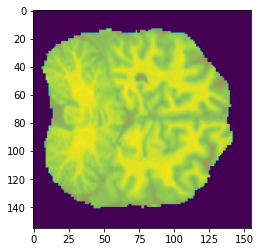

In [38]:
# test h5py
with h5py.File(h5_path_slices, 'r') as hf_slices:
    slice_img = hf_slices['image'][50]
    slice_mask = hf_slices['mask_brain'][50]
    plt.imshow(slice_img.astype(np.float32))
    plt.imshow(slice_mask.astype(np.uint8), alpha=0.5)

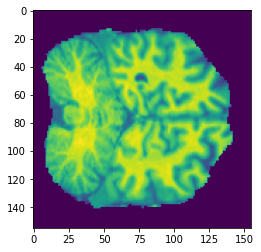

In [29]:
# test npy
fp = np.memmap(npy_path_slices, dtype='float16', mode='r', 
               shape=(shape[0]*len(keys), shape[1], shape[2]))
slice_img = fp[50]
plt.imshow(slice_img.astype(np.float32))    

In [39]:
# benchmark file reading (hdf5)
with h5py.File(h5_path_slices, 'r') as hf_slices:
    N = 10000
    t0 = time.perf_counter()
    print('starting hdf5 benchmark')
    for k in range(N):
        img = hf_slices['image'][k]
    t1 = time.perf_counter()
    print(f'total : N {N}, dt {t1-t0: .3f}s')
    print(f'per slice :{(t1-t0)/N: .3e}s')

starting hdf5 benchmark
total : N 10000, dt  7.464s
per slice : 7.464e-04s


In [40]:
# benchmark file reading (npy)
fp = np.memmap(npy_path_slices, dtype='float16', mode='r', 
            shape=(shape[0]*len(keys), shape[1], shape[2]))
N = 10000
t0 = time.perf_counter()
print('starting npy benchmark')
for k in range(N):
    img = np.array(fp[k])
t1 = time.perf_counter()
print(f'total : N {N}, dt {t1-t0: .3f}s')
print(f'per slice :{(t1-t0)/N: .3e}s')

starting npy benchmark
total : N 10000, dt  2.049s
per slice : 2.049e-04s
